In [28]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
from enum import Enum
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore 

import pandas as pd
import numpy as np


#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
common_path = os.path.abspath(os.path.join('..','src','common'))
print("{p2} {p1}".format(p1=common_path, p2=module_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(common_path)

from common.logger_init     import init_logger    
from common.result_value    import ResultValue, ResultOk, ResultKo    
from common.ChartTools      import set_axes_common_properties     


/Users/ERIZZAG5J/repos/JMeter_report/src /Users/ERIZZAG5J/repos/JMeter_report/src/common


In [29]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join(os.sep,"Users","ERIZZAG5J","Work","jmeter")
data_file_name = "merge_file.jtl"
csv_data_file = os.path.join(data_file_path, data_file_name)

image_file_prefix = "Test-"

class TypeOfOutputChart(Enum):
    PDF = 1
    PNG = 2
    JPG = 3

output_chart_type = TypeOfOutputChart.JPG

In [33]:
dtype_dict: dict = {'asset_id':str}
df = pd.read_csv(csv_data_file,low_memory=False, dtype=dtype_dict
                ,sep='#')  
(df.shape[0],df.dtypes)

(12515111,
 timeStamp            int64
 elapsed              int64
 label               object
 responseCode         int64
 responseMessage     object
 threadName          object
 dataType            object
 success               bool
 failureMessage      object
 bytes                int64
 sentBytes            int64
 grpThreads           int64
 allThreads           int64
 URL                 object
 Filename           float64
 Latency              int64
 SampleCount          int64
 ErrorCount           int64
 Hostname            object
 IdleTime             int64
 Connect              int64
 asset_id            object
 CACHE_HIT           object
 dtype: object)

In [37]:
max_elapsed = 300
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
unacceptable_elapsed.sort_values('elapsed', ascending=False).head(10)

,asset_id,elapsed,responseCode
549893,327,2074,200
549883,322,2068,200
342847,169412,2063,200
342839,169420,2020,200
3964166,1163,1753,200
8611064,369,1597,200
6331856,432637,1270,200
2157908,392317,1265,200
3948047,415018,1252,200
2157854,101,1133,200


Time (less than 150): 12512676 - (more than 150): 1837
Hit: 12374879 - Miss: 139505


Text(0.5, 1.0, 'Hit / Miss')

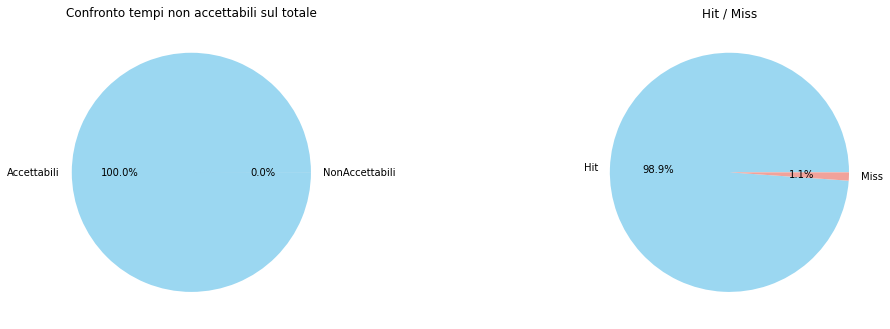

In [66]:
# --------------------------------------------------------------
# CONFIG SECTION
# --------------------------------------------------------------
max_elapsed = 150
cache_chart = True

# --------------------------------------------------------------
# DATA SECTION
# --------------------------------------------------------------
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
unacceptable_elapsed_num = unacceptable_elapsed.shape[0]

mask = (df["responseCode"] == 200)
total_transactions = df.loc[mask,:].shape[0]
acceptable_num = total_transactions - unacceptable_elapsed_num

print("Time (less than {t}): {ok} - (more than {t}): {ko}".format(ok=acceptable_num, ko=unacceptable_elapsed_num,t=max_elapsed))

mask = (df["CACHE_HIT"] == "Miss") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
miss_num = df.loc[mask,"CACHE_HIT"].shape[0]
mask = (df["CACHE_HIT"] == "Hit") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
hit_num = df.loc[mask,"CACHE_HIT"].shape[0]

print("Hit: {hit} - Miss: {miss}".format(hit=hit_num, miss=miss_num))

# --------------------------------------------------------------
# CHART SECTION
# --------------------------------------------------------------
fig = plt.figure(figsize=(15, 20))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig 
                       ,hspace=0.1
                       ,wspace=0.8)
ax = []
idx = 0
ax.append(fig.add_subplot(gs1[0,0]))

labels = ["NonAccettabili", "Accettabili"]

acceptable_color = "#f1a29b"
unacceptable_color = "#9bd7f1"
chart_unacc_acc = [unacceptable_elapsed_num, acceptable_num]

ax[idx].pie(chart_unacc_acc, labels=labels, colors=[aceptable_color, unaceptable_color], autopct='%1.1f%%')
ax[idx].set_title("Confronto tempi non accettabili sul totale", fontsize=12)

idx += 1
ax.append(fig.add_subplot(gs1[0,1]))

labels = ["Hit", "Miss"]
chart_hit_miss = [hit_num, miss_num]
hit_color = "#9bd7f1"
miss_color = "#f1a29b"

ax[idx].pie(chart_hit_miss, labels=labels, colors=[hit_color, miss_color], autopct='%1.1f%%')
ax[idx].set_title("Hit / Miss", fontsize=12)


In [68]:
df.isnull().sum()

timeStamp                 0
elapsed                   0
label                     0
responseCode              0
responseMessage          60
threadName                0
dataType                  0
success                   0
failureMessage     12514513
bytes                     0
sentBytes                 0
grpThreads                0
allThreads                0
URL                      69
Filename           12515111
Latency                   0
SampleCount               0
ErrorCount                0
Hostname                  0
IdleTime                  0
Connect                   0
asset_id                129
CACHE_HIT               129
dtype: int64

In [6]:
df.loc[:,["threadName","grpThreads","allThreads"]]

,threadName,grpThreads,allThreads
0,node-01 setUp Thread Group 1-1,1,1
1,node-01 setUp Thread Group 1-1,1,1
2,node-01 Manifest 1-1,1,1
3,node-01 Manifest 1-1,1,1
4,node-01 Manifest 1-1,1,1
...,...,...,...
922970,node-03 Manifest 1-19,3,3
922971,node-03 Manifest 1-18,2,2
922972,node-03 Manifest 1-6,1,1
922973,node-03 tearDown Thread Group 1-1,1,1


In [9]:
df.loc[:,"threadName"].unique()

array(['node-01 Manifest 1-1', 'node-01 Manifest 1-2',
       'node-01 Manifest 1-3', 'node-01 Manifest 1-4',
       'node-01 Manifest 1-5', 'node-01 Manifest 1-6',
       'node-01 Manifest 1-7', 'node-01 Manifest 1-8',
       'node-01 Manifest 1-9', 'node-01 Manifest 1-10',
       'node-01 Manifest 1-11', 'node-01 Manifest 1-12',
       'node-01 Manifest 1-13', 'node-01 Manifest 1-14',
       'node-01 Manifest 1-15', 'node-01 Manifest 1-16',
       'node-01 Manifest 1-17', 'node-01 Manifest 1-18',
       'node-01 Manifest 1-19', 'node-01 Manifest 1-20',
       'node-01 Manifest 1-21', 'node-01 Manifest 1-22',
       'node-01 Manifest 1-23', 'node-01 Manifest 1-24',
       'node-01 Manifest 1-25', 'node-01 Manifest 1-26',
       'node-01 Manifest 1-27', 'node-01 Manifest 1-28',
       'node-01 Manifest 1-29', 'node-01 Manifest 1-30',
       'node-01 Manifest 1-31', 'node-01 Manifest 1-32',
       'node-01 Manifest 1-33', 'node-01 Manifest 1-34',
       'node-01 Manifest 1-35', 'node-01